In [1]:
import pandas as pd
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import time
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [37]:
data = pd.read_csv('schedule_dataset.csv')
data.head(11588)

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время прибытия по расписанию,Время прибытия фактическое
0,01.03.2018,1,MOW,ARH,1,2018-03-01 02:00,2018-03-01 01:48
1,01.03.2018,2,MOW,EGO,2,2018-03-01 01:30,2018-03-01 01:55
2,01.03.2018,3,MOW,AKX,3,2018-03-01 02:40,2018-03-01 02:32
3,01.03.2018,4,LED,MOW,4,2018-03-01 01:35,2018-03-01 01:39
4,01.03.2018,5,MOW,KRR,5,2018-03-01 02:40,2018-03-01 02:41
5,01.03.2018,6,FRA,MOW,6,2018-03-01 03:25,2018-03-01 03:23
6,01.03.2018,7,AMS,MOW,7,2018-03-01 03:50,2018-03-01 03:57
7,01.03.2018,8,ZRH,MOW,8,2018-03-01 03:45,2018-03-01 03:34
8,01.03.2018,9,MOW,CEK,9,2018-03-01 03:05,2018-03-01 03:04
9,01.03.2018,10,MOW,SVX,10,2018-03-01 03:05,2018-03-01 03:15


In [4]:
# Сформировал массив со значениями (разница между временем по расписанию и фактическим)
DateFormat = "%Y-%m-%d %H:%M"
DateFormat2 = "%d.%m.%Y"

feature_time = list()
feature_data = list()
time_arrival = list()
time_actual = list()
for i in range(len(data)):
    arrival = datetime.strptime(data.loc[i]['Время прибытия по расписанию'], DateFormat)       # Преобразовал строку в дату
    time_arrival.append(time.mktime(arrival.timetuple()))                                      # Перевел в UNIX
    
    actual = datetime.strptime(data.loc[i]['Время прибытия фактическое'], DateFormat)          # Преобразовал строку в дату
    time_actual.append(time.mktime(actual.timetuple()))                                        # Перевел в UNIX
    
    feature = datetime.strptime(data.loc[i]['Дата рейса'], DateFormat2)                        # Преобразовал строку в дату
    feature_data.append(time.mktime(feature.timetuple()))                                      # Перевел в UNIX и записал в массив    
    

In [6]:
# Преобразовываю строковые признаки в числовые
сity_departure = set(data.loc[:]['А/П отправл'])  # Преобразую во множество, чтобы отфильтровать повторения
city_arrival = set(data.loc[:]['А/П прибыт'])     # Преобразую во множество, чтобы отфильтровать повторения

city = city_arrival.union(сity_departure)         # объединяю на случай, если города отправляения и прибытия разные
city = list(city)                                 # Преобразую в массив, чтобы можно было работать с индексами

In [7]:
# Сформирую словарь
city_dict = {}
for i in range(len(city)):
    city_dict[city[i]] = i

In [8]:
# Сформируем 2 списка признаков
сity_departure = list(data['А/П отправл'])
city_arrival = list(data['А/П прибыт'])

for i in range(len(data)):
    сity_departure[i] = city_dict[сity_departure[i]]
    city_arrival[i] = city_dict[city_arrival[i]]

In [9]:
# Сформируем таблицу из признаков
df = pd.DataFrame(data = data, columns=['Рейс','Номер ВС'])
df['Дата рейса'] = feature_data
df['А/П отправл'] = сity_departure
df['А/П прибыт'] = city_arrival
df['Время прибытия по расписанию'] = time_arrival

In [10]:
df.head()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
0,1,1,1.519852e+09,120,142,1.519859e+09
1,2,2,1.519852e+09,120,124,1.519857e+09
2,3,3,1.519852e+09,120,130,1.519861e+09
3,4,4,1.519852e+09,76,120,1.519857e+09
4,5,5,1.519852e+09,120,5,1.519861e+09


In [11]:
# Определим связи между признаками
df.corr()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
Рейс,1.000000,0.010280,0.115398,0.119205,-0.040326,0.118025
Номер ВС,0.010280,1.000000,0.086833,-0.016273,-0.016980,0.086958
Дата рейса,0.115398,0.086833,1.000000,0.008894,0.008493,0.999987
А/П отправл,0.119205,-0.016273,0.008894,1.000000,-0.291422,0.009309
А/П прибыт,-0.040326,-0.016980,0.008493,-0.291422,1.000000,0.007848
Время прибытия по расписанию,0.118025,0.086958,0.999987,0.009309,0.007848,1.000000


In [13]:
trn = df
trg = time_actual

In [14]:
#trn = scale(trn) # Приведем признаки к одному масштабу
#trn = pd.DataFrame(trn) # Преобразуем array обратно в DataFrame

In [16]:
# Разобъем исходные данные на тестовую и обучающую выборки
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)
Xtest.head()

,Рейс,Номер ВС,Дата рейса,А/П отправл,А/П прибыт,Время прибытия по расписанию
134706,1039,59,1.535404e+09,61,120,1.535475e+09
11587,195,206,1.521320e+09,15,120,1.521385e+09
75091,816,97,1.528837e+09,153,120,1.528922e+09
60617,675,82,1.527196e+09,120,146,1.527262e+09
87236,573,55,1.530220e+09,156,120,1.530304e+09


In [17]:
# Модели которые будем использовать
models = [LinearRegression(),                                             # метод наименьших квадратов
          #RandomForestRegressor(n_estimators=100, max_features ='sqrt'),  # случайный лес
          KNeighborsRegressor(n_neighbors=50),                             # метод ближайших соседей
          #SVR(kernel='linear'),                                           # метод опорных векторов с линейным ядром
          #LogisticRegression()                                            # логистическая регрессия
          ]

In [18]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    # Кладем в словарь с ключем - имя модели без (параметры)
    tmp['Model'] = m[:m.index('(')] 
    
    #обучаем
    model.fit(Xtrn, Ytrn) 
        
    #вычисляем коэффициент детерминации (качество прогноза)
    tmp['R2_Y'] = r2_score(Ytest, model.predict(Xtest))
        
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])
#делаем индекс по названию модели
TestModels.set_index('Model', inplace=True)

In [19]:
TestModels.head(6)

,R2_Y
Model,
LinearRegression,1.000000
KNeighborsRegressor,0.999999


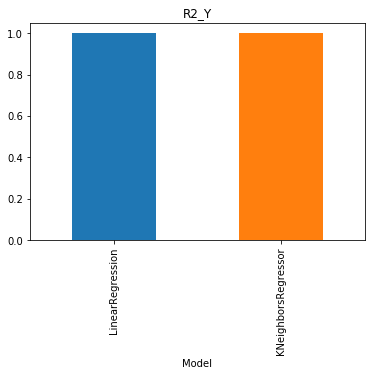

In [22]:
# Построим графики и посмотрим какая модель показала лучший результат
fig, axes = plt.subplots(ncols=1, figsize=(6,4))
TestModels.R2_Y.plot(ax=axes,kind='bar', title='R2_Y');

# Блок прогнозирования

In [34]:
model = models[0]
model.fit(Xtrn, Ytrn)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
#Построим прогноз
prediction = model.predict(Xtest)

In [36]:
# Преобразуем в читаемый формат
predictions_new = list()
for i in range(len(predictions)):
    predictions_new.append(datetime.fromtimestamp(prediction[i]))
predictions_new

[datetime.datetime(2018, 8, 28, 19, 54, 28, 488897),
 datetime.datetime(2018, 3, 18, 18, 1, 8, 734979),
 datetime.datetime(2018, 6, 13, 23, 43, 10, 335043),
 datetime.datetime(2018, 5, 25, 18, 34, 54, 435743),
 datetime.datetime(2018, 6, 29, 23, 30, 45, 780432),
 datetime.datetime(2018, 8, 30, 14, 5, 49, 776456),
 datetime.datetime(2018, 3, 23, 0, 13, 27, 9710),
 datetime.datetime(2018, 8, 1, 22, 40, 25, 562581),
 datetime.datetime(2018, 8, 11, 12, 24, 30, 681344),
 datetime.datetime(2018, 8, 27, 23, 29, 51, 114716),
 datetime.datetime(2018, 5, 6, 1, 11, 15, 634816),
 datetime.datetime(2018, 7, 2, 12, 26, 11, 211623),
 datetime.datetime(2018, 4, 23, 16, 16, 26, 199051),
 datetime.datetime(2018, 3, 10, 15, 46, 37, 317168),
 datetime.datetime(2018, 8, 20, 17, 19, 26, 198824),
 datetime.datetime(2018, 7, 6, 5, 40, 25, 217580),
 datetime.datetime(2018, 4, 14, 17, 17, 29, 13975),
 datetime.datetime(2018, 5, 1, 17, 12, 44, 85844),
 datetime.datetime(2018, 4, 30, 18, 39, 16, 364),
 datetime.d